In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import random
from datasets import load_dataset
# from torchinfo import summary
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from torch.optim.lr_scheduler import LambdaLR
import requests
import os
import tarfile
import re
from IPython.display import clear_output

/Users/michalmraz/Desktop/ML_project/ml_project_venv/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True  # slower but deterministic
    torch.backends.cudnn.benchmark = False

In [4]:
def generate_causal_mask(seq_len):
    # Create a matrix with ones in the lower triangle, zeros above
    mask = torch.tril(torch.ones(seq_len, seq_len))
    return mask  # shape (seq_len, seq_len)

In [5]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k):
        super().__init__()
        self.scale = d_k ** 0.5

    def forward(self, Q, K, V, causal_mask=False, padding_mask=None):
        # Q, K, V: (batch_size, num_heads, seq_len, d_k)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale  # (B, H, L, L)

        if causal_mask:
            causal_mask = generate_causal_mask(scores.size(-1)).expand(scores.size(0), scores.size(1), -1, -1).to(scores.device)
            scores = scores.masked_fill(causal_mask == 0, float('-inf'))
        if padding_mask is not None:
            padding_mask = padding_mask.unsqueeze(1).unsqueeze(2)  # (batch, 1, 1, seq_len)
            scores = scores.masked_fill(padding_mask == 0, float('-inf'))  # Mask out pad positions

        attention_weights = F.softmax(scores, dim=-1)  # (B, H, L, L)
        output = torch.matmul(attention_weights, V)    # (B, H, L, d_k)
        return output

In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_embedding, num_heads, dropout=0):
        super().__init__()
        assert d_embedding % num_heads == 0
        self.d_k = d_embedding // num_heads
        self.num_heads = num_heads

        #in reality these can map to a lower dimensional space to make things faster``
        self.W_q = nn.Linear(d_embedding, d_embedding)
        self.W_k = nn.Linear(d_embedding, d_embedding)
        self.W_v = nn.Linear(d_embedding, d_embedding)
        self.W_o = nn.Linear(d_embedding, d_embedding)

        self.attention = ScaledDotProductAttention(self.d_k)

        self.norm = nn.LayerNorm(d_embedding)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, causal_mask=False, padding_mask=None):
        x_input = x
        x = self.norm(x)

        B, L, d_embedding = x.size()  # Batch, Sequence Length, Embedding Dim
        H = self.num_heads

        # Linear projections
        Q = self.W_q(x).view(B, L, H, self.d_k).transpose(1, 2)  # (B, H, L, d_k)
        K = self.W_k(x).view(B, L, H, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(B, L, H, self.d_k).transpose(1, 2)

        # Apply attention
        context = self.attention(Q, K, V, causal_mask, padding_mask)  # (B, H, L, d_k)

        # Concatenate heads
        context = context.transpose(1, 2).contiguous().view(B, L, d_embedding)  # (B, L, d_embedding)

        # Final linear projection
        output = self.W_o(context)  # (B, L, d_embedding)
        output = self.dropout(output)

        # Add (& pre-Norm)
        #my preference is to do pre-norm for better stabiliy, even though the original paper used post-norm
        output = x_input + output
        return output


In [7]:
class MultiHeadCrossAttention(nn.Module):
    def __init__(self, d_embedding, num_heads, dropout=0):
        super().__init__()
        assert d_embedding % num_heads == 0
        self.d_k = d_embedding // num_heads
        self.num_heads = num_heads

        self.W_q = nn.Linear(d_embedding, d_embedding)
        self.W_k = nn.Linear(d_embedding, d_embedding)
        self.W_v = nn.Linear(d_embedding, d_embedding)
        self.W_o = nn.Linear(d_embedding, d_embedding)

        self.attention = ScaledDotProductAttention(self.d_k)

        self.norm = nn.LayerNorm(d_embedding)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x_decoder, x_encoder, causal_mask=False, padding_mask=None):
        assert x_decoder.size() == x_encoder.size() #x and x_encoder must have the same size
        x_input = x_decoder
        x_decoder = self.norm(x_decoder)
        
        B, L, d_embedding = x_decoder.size()  # Batch, Sequence Length, Embedding Dim
        H = self.num_heads

        # Linear projections
        Q = self.W_q(x_decoder).view(B, L, H, self.d_k).transpose(1, 2)  # (B, H, L, d_k)
        K = self.W_k(x_encoder).view(B, L, H, self.d_k).transpose(1, 2)
        V = self.W_v(x_encoder).view(B, L, H, self.d_k).transpose(1, 2)

        # Apply attention
        context = self.attention(Q, K, V, causal_mask, padding_mask)  # (B, H, L, d_k)

        # Concatenate heads
        context = context.transpose(1, 2).contiguous().view(B, L, d_embedding)  # (B, L, d_embedding)

        # Final linear projection
        output = self.W_o(context)  # (B, L, d_embedding)
        output = self.dropout(output)

        output = output + x_input
        return output


In [8]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, d_embedding, d_ff, dropout=0):
        super().__init__()
        self.linear1 = nn.Linear(d_embedding, d_ff)
        self.linear2 = nn.Linear(d_ff, d_embedding)
        self.activation = nn.ReLU()
        self.norm = nn.LayerNorm(d_embedding)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x_input = x
        x = self.norm(x)
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.dropout(x)
        x = x_input + x
        return x

In [9]:
class Encoder(nn.Module):
    def __init__(self, d_embedding, num_heads, d_ff, num_layers, dropout=0):
        super().__init__()
        self.layers = nn.ModuleList([
            MultiHeadAttention(d_embedding, num_heads, dropout=dropout),
            FeedForwardNetwork(d_embedding, d_ff, dropout=dropout)
        ] * num_layers)
    
    def forward(self, x, causal_mask=False, padding_mask=None):
        for i, layer in enumerate(self.layers):
            if i % 2 == 0:
                x = layer(x, causal_mask=causal_mask, padding_mask=padding_mask)
            else:
                x = layer(x)
        return x

In [10]:
class Decoder(nn.Module):
    def __init__(self, encoder, d_embedding, num_heads, d_ff, num_layers, vocab_size, dropout=0):
        super().__init__()
        self.encoder = encoder
        self.layers = nn.ModuleList([
            MultiHeadAttention(d_embedding, num_heads, dropout=dropout),
            MultiHeadCrossAttention(d_embedding, num_heads, dropout=dropout),
            FeedForwardNetwork(d_embedding, d_ff, dropout=dropout)
        ] * num_layers)
        self.linear = nn.Linear(d_embedding, vocab_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x_decoder, x_encoder, causal_mask=False, encoder_padding_mask=None, decoder_padding_mask=None, inference=False):
        for i, layer in enumerate(self.layers):
            if i % 3 == 0:
                x_decoder = layer(x_decoder, causal_mask=causal_mask, padding_mask=decoder_padding_mask)
            elif i % 3 == 1:
                x_decoder = layer(x_decoder, x_encoder, causal_mask=False, padding_mask=encoder_padding_mask)
            else:
                x_decoder = layer(x_decoder)
        x_decoder = self.linear(x_decoder)
        if inference:
            x_decoder = self.softmax(x_decoder)
        return x_decoder

In [11]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, d_embedding, max_len, dropout=0): 
        #max_len is the maximum length of the input sequence
        super().__init__()
        self.embedding = nn.Parameter(torch.randn(vocab_size, d_embedding))

        pe = torch.zeros(max_len, d_embedding)
        powers = torch.repeat_interleave(torch.arange(0, 1, 2/d_embedding), repeats=2).expand(max_len, -1)
        divisors = torch.pow(10000, powers)
        positions = torch.arange(0, max_len).view(max_len, -1).expand(-1, d_embedding)
        args = positions / divisors
        pe[:, 0::2] = torch.sin(args[:, 0::2])
        pe[:, 1::2] = torch.cos(args[:, 1::2])

        # Register as buffer so it's not a parameter but moves with `.to(device)`
        self.register_buffer('pe', pe)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (batch_size, seq_len)
        Returns:
            Tensor of shape (batch_size, seq_len, d_embedding)
        """
        seq_len = x.size(1)
        # Add positional encoding: broadcast over batch dimension
        x = self.embedding[x] + self.pe[:seq_len]
        x = self.dropout(x)
        return x

In [12]:
def create_padding_mask(padded_input, pad_token_id=0):
    return (padded_input != pad_token_id).int()  # shape: (batch, seq_len)

In [13]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, d_embedding, num_heads, d_ff, num_layers, max_len, dropout=0):
        super().__init__()
        self.embedding = Embedding(vocab_size, d_embedding, max_len, dropout=dropout)
        self.encoder = Encoder(d_embedding, num_heads, d_ff, num_layers, dropout=dropout)
        self.decoder = Decoder(self.encoder, d_embedding, num_heads, d_ff, num_layers, vocab_size, dropout=dropout)

    def forward(self, x_encoder, x_decoder, causal_mask=False):
        encoder_padding_mask = create_padding_mask(x_encoder)
        decoder_padding_mask = create_padding_mask(x_decoder)

        x_encoder = self.embedding(x_encoder)
        x_decoder = self.embedding(x_decoder)
        x_encoder = self.encoder(x_encoder, causal_mask=False, padding_mask=encoder_padding_mask)
        output = self.decoder(x_decoder, x_encoder, causal_mask=causal_mask, encoder_padding_mask=encoder_padding_mask, decoder_padding_mask=decoder_padding_mask)
        return output

In [14]:
# data = load_dataset('opus_books', 'en-sk')

In [15]:
# Save the name of the model whose tokenizer we are using. We will need it later.
PRE_TRAINED_MODEL_NAME = "distilbert/distilbert-base-multilingual-cased"

# Download the tokenizer
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [16]:
# params
vocab_size = tokenizer.vocab_size #119547
max_len = 128
d_embedding = 256
d_ff = 1024
num_heads = 8
num_layers = 6
dropout=0

In [17]:
dont_have_presaved_data = False
#only set to true if I don't have 'tokenized_dataset_tensor.pt' in the current folder. Takes 15 min in total to download and tokenize the dataset

if dont_have_presaved_data:
    url = "http://www.statmt.org/europarl/v7/sk-en.tgz"
    filename = "sk-en.tgz"

    if not os.path.exists(filename):
        r = requests.get(url)
        with open(filename, "wb") as w:
            w.write(r.content)
        print("File downloaded")
    else:
        print("File already exists")
    # Open a gzipped tar file in read mode
    with tarfile.open("sk-en.tgz", "r:gz") as tar:
        # Get a TarFile object for the archive
        # Extract all the files and directories to the current folder
        tar.extractall()
    # Define a function for text cleaning
    def clean_text(text):

        # Convert text to lowercase
        text = str(text).lower().strip()

        # Remove the \n at the end of each line in the file
        text = text.rstrip('\n')

        # Remove HTML tags and non-alphanumeric characters
        text = re.sub(r"<[^>]+>", "", text)
        text = re.sub(r"[^a-zA-ZÀ-ž0-9\s.,;!?':()\[\]{}-]", " ", text)  # Keep selected punctuation marks, symbols and apostrophes

        # Remove excessive whitespace (more than one space)
        text = re.sub(r"\s+", " ", text)

        text = text.encode("utf-8", errors="ignore").decode("utf-8")  # Corrected encoding

        return text
    
    # Read from the two text files, and create a pandas Series object (like a python list[]), and clean the text by
    # applying our clean_text function to every element.

    with open('europarl-v7.sk-en.en', 'r') as en_file, open('europarl-v7.sk-en.sk', 'r') as sk_file:
        en = pd.Series(en_file.readlines(), name='en').apply(lambda text: clean_text(text))
        sk = pd.Series(sk_file.readlines(), name='sk').apply(lambda text: clean_text(text))
    translation_df = pd.concat([en, sk], axis=1)

    # this takes over 10 min so I save the result and load it
    tokenized = [{
        'en': tokenizer.encode(translation_df.loc[i,'en'], return_tensors='pt', padding='max_length', max_length=max_len, truncation=True, add_special_tokens=True),
        'sk': tokenizer.encode(translation_df.loc[i,'sk'], return_tensors='pt', padding='max_length', max_length=max_len, truncation=True, add_special_tokens=True)
    } for i in range(translation_df.shape[0])]


    # First, separate English and Slovak tensors
    en_tensors = [item['en'] for item in tokenized]  
    sk_tensors = [item['sk'] for item in tokenized]  

    # Stack them into 3D tensors (num_sentences, max_len)
    en_tensor = torch.stack(en_tensors)
    sk_tensor = torch.stack(sk_tensors)
    tokenized_dataset_tensor = torch.stack([en_tensor, sk_tensor])
    torch.save(tokenized_dataset_tensor, 'tokenized_dataset_tensor.pt')
else:
    tokenized_dataset_tensor = torch.load('tokenized_dataset_tensor.pt')

In [18]:
# Dummy input extras
seq_len = 5
batch_size = 2

x_test = torch.randn(batch_size, seq_len, d_embedding)

In [19]:
set_seed(42)

In [20]:
transformer = Transformer(
    vocab_size=vocab_size,
    d_embedding=d_embedding,
    num_heads=num_heads,
    d_ff=d_ff,
    num_layers=num_layers,
    max_len=max_len,
    dropout=dropout)

In [27]:
#max_len in dataset is 566 but I'm happy to go with 512 

In [28]:
class TranslationDataset(Dataset):
    def __init__(self, tokenized_dataset_tensor):
        self.tokenized_dataset_tensor = tokenized_dataset_tensor

    def __len__(self):
        return self.tokenized_dataset_tensor.shape[1]

    def __getitem__(self, idx):
        return (self.tokenized_dataset_tensor[0][idx], self.tokenized_dataset_tensor[1][idx])
        # 0 for English, 1 for Slovak

dataset = TranslationDataset(tokenized_dataset_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [29]:
cel = torch.nn.CrossEntropyLoss(ignore_index=0)

optimizer = torch.optim.Adam(transformer.parameters(), betas=(0.9, 0.98), eps=1e-9, lr=1e-4) #betas and eps from the original paper
optimizer = torch.optim.Adam(transformer.parameters(), lr=1e-4) 

In [30]:
gradient_accumulation_steps = 5
warmup_steps = 100 / gradient_accumulation_steps

def lr_lambda(step_num): #lr decay from original paper. We use fewer warmups
    step_num = step_num + 1 #to avoid division by zero warning at step 0
    # return min(1/np.sqrt(step_num), step_num / math.pow(warmup_steps, 1.5)) / np.sqrt(d_embedding) #og paper lr decay
    #default inverse square root decay at 0.5
    decay_speed = 0.3
    # return min(math.pow(step_num, -decay_speed), step_num * math.pow(warmup_steps, -(1+decay_speed))) / np.sqrt(d_embedding) #og paper lr decay
    return min(math.pow(step_num, -decay_speed), step_num * math.pow(warmup_steps, -(1+decay_speed))) * 10


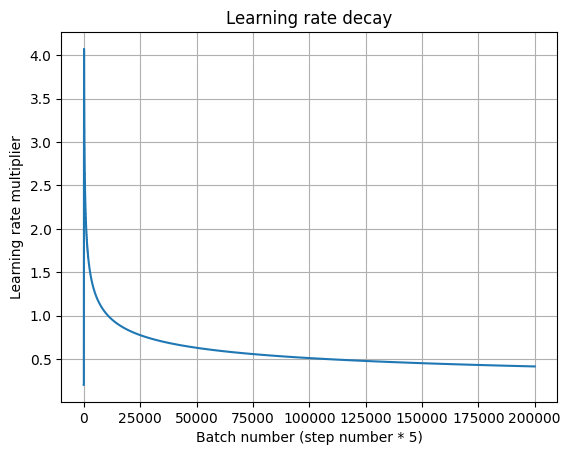

In [31]:
x = [i for i in range(40000*5)]
y = [lr_lambda(i//5) for i in x]
plt.plot(x, y)
plt.xlabel(f'Batch number (step number * {gradient_accumulation_steps})')
plt.ylabel('Learning rate multiplier')
plt.title('Learning rate decay')
plt.grid()

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformer = transformer.to(device)

In [33]:
scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
# we don't use label smoothing yet. migh implement later

In [ ]:
version = 8

In [ ]:
# kek

NameError: name 'kek' is not defined

In [ ]:
# Plotting
losses = []
grad_norms = {n: [] for n, p in transformer.named_parameters() if p.requires_grad}
batch_indices = []
plt.ion()

# Utility
count = 0
optimizer.zero_grad()
n_epochs = 5

for epoch in range(1, n_epochs + 1):
    print(f"Epoch {epoch}/{n_epochs}")
    for batch_data, batch_labels in tqdm(dataloader):
        count += 1
        batch_data = batch_data.squeeze(1).to(device)  # Remove the extra dimension
        batch_labels = batch_labels.squeeze(1).to(device)  # Remove the extra dimension

        output = transformer(batch_data, batch_labels, causal_mask=True)

        loss = cel(output.permute(0, 2, 1)[:, :, :-1], batch_labels[:, 1:]) / gradient_accumulation_steps
        loss.backward()

        if count % gradient_accumulation_steps == 0:
            latest_grad_norms = {}  # Store the latest gradient norms for bar plot
            for name, param in transformer.named_parameters():
                if param.grad is not None:
                    grad_norm = param.grad.norm(2).item()
                    grad_norms[name].append(grad_norm)
                    latest_grad_norms[name] = grad_norm  # Store the latest gradient norm

            torch.nn.utils.clip_grad_norm_(transformer.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        losses.append(loss.item())
        batch_indices.append(count)

        # Update the plots every 100 batches or at the end of an epoch
        if (count % 100 == 0) or (count % len(dataloader) == 0):
            clear_output(wait=True)
            fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

            # Plot training loss
            ax[0].plot(batch_indices, losses, label='Training Loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_ylabel('Loss')
            ax[0].set_title('Training Loss')
            ax[0].legend()
            ax[0].grid(True)

            # Plot gradient magnitudes (Top 5)
            grad_norms_df = pd.DataFrame(grad_norms)
            grad_norms_df.index = (grad_norms_df.index + 1) * gradient_accumulation_steps
            grad_norms_df[grad_norms_df.iloc[-1].nlargest(5).index].plot(ax=ax[1])
            ax[1].set_xlabel('Batch')
            ax[1].set_ylabel('Gradient Norm (L2)')
            ax[1].set_title('Gradient Magnitudes (Top 5)')
            ax[1].grid(True)

            # Bar plot of all latest gradient norms
            names, norms = zip(*latest_grad_norms.items())
            ax[2].bar(names, norms)
            ax[2].set_xticks(range(len(names)))
            ax[2].set_xticklabels(names, rotation=90)
            ax[2].set_ylabel('Gradient Norm (L2)')
            ax[2].set_title('Latest Gradient Magnitudes (All)')
            ax[2].grid(True)

            # Save plots at the end of an epoch
            if count % len(dataloader) == 0:
                plt.savefig(f"training_and_grad_norms_v{version}_epoch_{epoch}.png")

            plt.tight_layout()
            plt.show()

    torch.save(transformer.state_dict(), f"transformer_v{version}_epoch_{epoch}.pth")

In [ ]:
transformer.load_state_dict(torch.load("transformer_epoch_3_v7.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
#inference baby

In [ ]:
def translate_sentence(sentence, model, tokenizer, device, max_len=max_len):
    model.eval()
    with torch.no_grad():
        # Tokenize input sentence and convert to tensor
        # input_ids = tokenizer.encode(sentence, return_tensors="pt").to(device)
        input_ids = tokenizer(sentence, return_tensors='pt', padding='max_length', max_length=max_len, truncation=True)['input_ids']

        # Create attention mask (1 for non-pad tokens)
        encoder_padding_mask = create_padding_mask(input_ids, pad_token_id=0)

        # Pass through encoder
        input_ids = model.embedding(input_ids)
        encoder_outputs = model.encoder(input_ids, padding_mask=encoder_padding_mask)

        # Initialize decoder input with BOS token
        # decoder_input = torch.tensor([[tokenizer.bos_token_id]], device=device)
        decoder_input = torch.tensor([[tokenizer.cls_token_id]], device=device)

        translated_tokens = []

        for i in range(max_len):
            # Create causal mask and decoder attention mask if needed
            decoder_padding_mask = create_padding_mask(decoder_input)
            decoder_input_embedded = model.embedding(decoder_input)
            filler = torch.zeros(encoder_outputs.size(0), encoder_outputs.size(1) - decoder_input_embedded.size(1), encoder_outputs.size(2))
            decoder_input_embedded = torch.cat([decoder_input_embedded, filler], dim=1)
            filler = torch.zeros(decoder_padding_mask.size(0), encoder_padding_mask.size(1) - decoder_padding_mask.size(1))
            decoder_padding_mask = torch.cat([decoder_padding_mask, filler], dim=1)
            # decoder_input_embedded = decoder_input_embedded.expand(encoder_outputs.size())

            # Forward pass through model
            outputs = model.decoder(
                decoder_input_embedded,
                encoder_outputs,
                causal_mask=True,
                # causal_mask=False,
                decoder_padding_mask=decoder_padding_mask,
                encoder_padding_mask=encoder_padding_mask
            )

            next_token_logits = outputs[:, i, :]  # (1, vocab_size)

            # Pick token with highest probability
            next_token_id = torch.argmax(next_token_logits, dim=-1).item()

            # Append predicted token
            translated_tokens.append(next_token_id)


            # Update decoder input
            decoder_input = torch.cat(
                [decoder_input, torch.tensor([[next_token_id]], device=device)], dim=1
            )

            # Break if EOS
            # if next_token_id == tokenizer.eos_token_id:
            if next_token_id == tokenizer.sep_token_id:
                break

        # Decode tokens into sentence
        translated_sentence = tokenizer.decode(translated_tokens, skip_special_tokens=True)
        return translated_sentence



In [ ]:
def translate_sentence_beam_search(sentence, model, tokenizer, device, max_len=max_len, beam_width=3, length_penalty=0.6):
    # length_penalty = 0 makes it equivalent to normal beam search
    model.eval()
    with torch.no_grad():
        # Tokenize input sentence and convert to tensor
        # input_ids = tokenizer.encode(sentence, return_tensors="pt").to(device)
        input_ids = tokenizer(sentence, return_tensors='pt', padding='max_length', max_length=max_len, truncation=True)['input_ids']

        # Create attention mask (1 for non-pad tokens)
        encoder_padding_mask = create_padding_mask(input_ids, pad_token_id=0)

        # Pass through encoder
        input_ids = model.embedding(input_ids)
        encoder_outputs = model.encoder(input_ids, padding_mask=encoder_padding_mask)

        # Initialize decoder input with BOS token
        # decoder_input = torch.tensor([[tokenizer.bos_token_id]], device=device)
        decoder_input = torch.tensor([[tokenizer.cls_token_id]], device=device)

        # translated_tokens = []
        # Beam search variables
        hypotheses = [(decoder_input, 0)]  # List of (current_sequence, cumulative_log_prob)
        completed_hypotheses = []

        for i in range(max_len):
            all_candidates = []
            for seq, cumulative_log_prob in hypotheses:
                # Create causal mask and decoder attention mask if needed
                decoder_padding_mask = create_padding_mask(seq)
                decoder_input_embedded = model.embedding(seq)
                filler = torch.zeros(encoder_outputs.size(0), encoder_outputs.size(1) - decoder_input_embedded.size(1), encoder_outputs.size(2))
                decoder_input_embedded = torch.cat([decoder_input_embedded, filler], dim=1)
                filler = torch.zeros(decoder_padding_mask.size(0), encoder_padding_mask.size(1) - decoder_padding_mask.size(1))
                decoder_padding_mask = torch.cat([decoder_padding_mask, filler], dim=1)
                # decoder_input_embedded = decoder_input_embedded.expand(encoder_outputs.size())

                # Forward pass through model
                outputs = model.decoder(
                    decoder_input_embedded,
                    encoder_outputs,
                    causal_mask=True,
                    # causal_mask=False,
                    decoder_padding_mask=decoder_padding_mask,
                    encoder_padding_mask=encoder_padding_mask
                )

                next_token_logits = outputs[:, i, :]  # (1, vocab_size)
                next_token_probs = torch.log_softmax(next_token_logits, dim=-1).squeeze(0)

                # Get top `beam_width` tokens and their log probabilities
                topk_probs, topk_ids = torch.topk(next_token_probs, beam_width)

                # Create new candidates
                for i in range(beam_width):
                    new_seq = torch.cat([seq, topk_ids[i].unsqueeze(0).unsqueeze(0)], dim=1)
                    new_log_prob = cumulative_log_prob + topk_probs[i].item()
                    all_candidates.append((new_seq, new_log_prob))

            # Sort all candidates by cumulative log probability and keep the top `beam_width`
            all_candidates = sorted(all_candidates, key=lambda x: x[1], reverse=True)
            hypotheses = all_candidates[:beam_width]

            # Check for completed hypotheses (those ending with SEP token)
            new_hypotheses = []  # Create a new list for remaining hypotheses
            for seq, log_prob in hypotheses:
                if seq[0, -1].item() == tokenizer.sep_token_id:  # Use .item() to extract scalar value
                    completed_hypotheses.append((seq, log_prob / (seq.shape[1] ** length_penalty)))  # Apply length penalty
                else:
                    new_hypotheses.append((seq, log_prob))  # Keep this hypothesis if not completed
            hypotheses = new_hypotheses  # Update the hypotheses list

            # If all hypotheses are completed, stop early
            if len(hypotheses) == 0:
                break
        
        # If no completed hypotheses, use the current hypotheses
        if len(completed_hypotheses) == 0:
            completed_hypotheses = [(h[0], h[1] / (h[0].shape[1] ** length_penalty)) for h in hypotheses]
        
        # Select the best hypothesis (highest log probability)
        best_hypothesis = max(completed_hypotheses, key=lambda x: x[1])[0]

        # Decode tokens into sentence
        translated_sentence = tokenizer.decode(best_hypothesis.squeeze(0), skip_special_tokens=True)
        return translated_sentence



In [ ]:
#for my local work 
# device = torch.device("cpu")

In [ ]:
print(translate_sentence("Slovakia is a beautiful country.", transformer, tokenizer, device="cpu"))

je to najväčšia krajina.


In [ ]:
print(translate_sentence("Relations between the European Union and Russia following the assassination of journalist.", transformer, tokenizer, device="cpu"))

po prvýmôže výzvy a po získavaní po výsledku.


In [ ]:
print(translate_sentence("Approval of Minutes of previous sitting: see Minutes.", transformer, tokenizer, device="cpu"))

predchádzajúcich rokovaniach o predchádzajúcom z predchádzajúcich rokov.


In [ ]:
print(translate_sentence_beam_search("Slovakia is a beautiful country.", transformer, tokenizer, device="cpu"))

je široká krajina.


In [ ]:
print(translate_sentence_beam_search("Approval of Minutes of previous sitting: see Minutes.", transformer, tokenizer, device="cpu"))

predchádzajúceádzaádzaádza z predádzajúceádzaádzajúádzajúádzaádzaádzajúádzaádzaádzaádzaádzaádza.


project idea \
it can predict sequence of numbers, in words. \
two four six eight ten - twelve \
three six nine twelve - fifteen \
could be arithmetic and geometric. I will generate them, code up the number to string mapper, pass it mapped to strings